In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from numba import jit, njit, prange
from quantecon.util import tic, toc

In [2]:
@njit
def u(c, l, cpsi, ceta):
    return np.log(c) - cpsi * (l)**(1 + ceta)/(1 + ceta)

In [7]:
class AiyagariProb:
    
    def __init__(self,
                 r=0.01,                      # interest rate
                 w=1.0,                       # wages
                 cpsi = 1,
                 ceta = 1.25,
                 cbeta=0.96,                  # discount factor
                 a_min=1e-10,
                 P=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                 z_vals=[0.1, 1.0],           # exogenous states
                 a_max=18,
                 a_size=200
                 ):
        
        #making all options class objects
        self.r, self.w, self.cpsi, self.ceta, self.cbeta = r, w, cpsi, ceta, cbeta 
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size
        self.P, self.z_vals = np.asarray(P), np.asarray(z_vals)
        self.z_size = len(z_vals)
        self.l_size = a_size
        
        self.a_grid = np.linspace(a_min, a_max, a_size)
        self.l_grid = np.linspace(1e-6, 1, a_size)
    
    def pack_params(self):
        return self.r, self.w, self.cpsi, self.ceta, self.cbeta, self.a_min, self.a_max, self.a_size, self.P, self.z_vals, self.a_grid, self.l_grid
        
    def bellman_operator(self):
        
        r, w, cpsi, ceta, cbeta, a_min, a_max, a_size, P, z_vals, a_grid, l_grid = self.pack_params()
        
        @njit
        def T(v, v_out, pola, poll):
            for j, z in enumerate(z_vals):
                for i, x in enumerate(a_grid):
                    for l_i, l in enumerate(l_grid):
                        y = (1.0 + r) * x + w * z * l
                        max_so_far = - np.inf
                        # Find largest x_grid index s.t. x' <= y
                        idx = np.searchsorted(a_grid, y)
                        # Step through x' with 0 <= x' <= y, find max
                        for k in range(idx):
                            x_next = a_grid[k]
                            val = u(y - x_next, l, cpsi, ceta) + cbeta * np.sum(v[k + l_i, :] * P[j, :])
                            if val > max_so_far:
                                max_so_far = val
                                a_star = k
                                l_star = l_i

                        pola[i, j] = a_star
                        poll[l_i, j] = l_star
                        v_out[i + l_i, j] = max_so_far

        return T

In [8]:
@njit
def vfi(T, v_init, pol_init, tol=1e-4, max_iter=1000):

    # Set initial condition, set up storage
    v_in = v_init
    v_out = np.empty_like(v_in)
    pola = pol_init
    poll = np.empty_like(pola, dtype=np.int_)
    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        T(v_in, v_out, pola, poll)
        error = np.max(np.abs(v_in - v_out))
        i += 1
        v_in[:] = v_out
    return v_out, pola, poll

In [37]:
mod = AiyagariProb()
T = mod.bellman_operator()
v_init = np.ones((2 * (mod.a_size), mod.z_size))
pol_init = np.empty((mod.a_size, mod.z_size), dtype=np.int_)

In [38]:
tic()
v_star, pola, poll = vfi(T, v_init, pol_init)
toc()

TOC: Elapsed: 0:04:37.99


277.99577474594116

In [39]:
@njit(parallel=True)
def simulate_stationary(pol, 
                        P, 
                        a_grid, 
                        i_init=10, 
                        j_init=0, 
                        num_households=100_000,
                        ts_length=1000):
    
    asset_vals = np.empty(num_households)
    for m in prange(num_households):
        i = i_init
        j = j_init

        for t in range(ts_length-1):
            i = pol[i, j]
            j = qe.random.draw(np.cumsum(P[j, :]))
            
        asset_vals[m] = a_grid[i]
        
    return asset_vals

TOC: Elapsed: 0:00:12.35


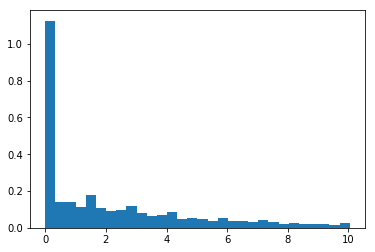

In [40]:
tic()
asset_vals = simulate_stationary(pola,mod.P, mod.a_grid)
toc()
fig, ax = plt.subplots()
ax.hist(asset_vals, bins = 30, density=True)
plt.show()

TOC: Elapsed: 0:00:11.69


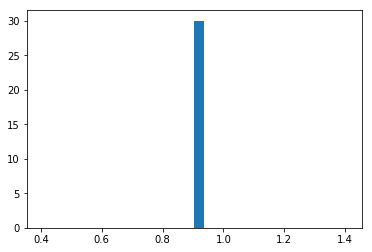

In [44]:
tic()
lab_vals = simulate_stationary(poll,mod.P, mod.a_grid)
toc()
fig, ax = plt.subplots()
ax.hist(lab_vals, bins = 30, density=True)
plt.show()

In [ ]:
A = 1.0
N = 1.0
calpha = 0.33
cbeta = 0.96
cdelta = 0.05
cpsi = 1
ceta = 1.25


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    
    return (A * (1 - calpha) * (A * calpha / (r + cdelta))**(calpha / (1 - calpha)))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return (A * calpha * (L / K)**(1 - calpha) - cdelta)

def prices_to_capital_stock():
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    asset_vals = simulate_stationary(pola,mod.P, mod.a_grid)
    return np.mean(asset_vals)

def prices_to_labour_supply():
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    lab = simulate_stationary(poll,mod.P, mod.l_grid)
    return np.sum(lab * )